In [17]:
# import necessary files
import serial
import numpy as np 
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [2]:
def readArduinoData():
    data = []
    PORT = 0
    while True:
        try:
            RGBcircuit = serial.Serial("COM"+str(PORT), baudrate=9600, timeout=1)
            break
        except:
            PORT = PORT + 1

    print("PORT Connected to COM" + str(PORT))

    for index in range(1000):
        try:
            tempData = list(map(int ,RGBcircuit.readline().decode()[:-1].split(", ")))
            data.append(tempData)
        
            if index % 100 == 0:
                print("Progress -> {} %".format(index / 10))

        except UnicodeDecodeError:
            pass

        except KeyboardInterrupt:
            exit()

        except ValueError:
            exit()

    RGBcircuit.close()
    data = np.array(data, dtype="int16")
    average = np.mean(data, axis=1)
   
    return data, average

In [3]:
data, average = readArduinoData()

PORT Connected to COM6
Progress -> 10.0 %
Progress -> 20.0 %
Progress -> 30.0 %
Progress -> 40.0 %
Progress -> 50.0 %
Progress -> 60.0 %
Progress -> 70.0 %
Progress -> 80.0 %
Progress -> 90.0 %


In [20]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [60]:
def processRatio(average, data):
    average = average.reshape(-1, 1).astype("int16") # reshape the average
    result = np.hstack((data, average)) # connect average with the data

    # Now it is time to group the data
    results=[]
    for x in sorted(np.unique(result[...,3])):
        results.append([    np.average(result[np.where(result[...,3]==x)][...,0]),
                            np.average(result[np.where(result[...,3]==x)][...,1]), 
                            np.average(result[np.where(result[...,3]==x)][...,2]), 
                            x])

    results = np.array(results, dtype="float64")

    _ , ax = plt.subplots(1, 1, sharex=True, figsize = (18, 14))

    ax.set_ylim(150, 800)
    ax.set_xlim(300, 670)

    major_xticks = np.arange(300, 670, 50)
    minor_xticks = np.arange(300, 670, 10)

    major_yticks = np.arange(150, 850, 50)
    minor_yticks = np.arange(150, 850, 10)


    ax.set_xlabel("Average Between RGB readings")

    ax.set_title("Average vs RGB Raw readings")
    ax.set_ylabel("RGB Raw Readings")

    #ax.plot(results[:, 3], smooth(results[:, 0], 20), 'r', label="Red Ratio")
    #ax.plot(results[:, 3], smooth(results[:, 1], 20), 'g', label="Green Ratio")
    #ax.plot(results[:, 3], smooth(results[:, 2], 20), 'b', label="Blue Ratio")

    
    #red green blue equation
    red   = 40.5785 * np.sqrt(results[:, 3] -42.1185) - 239.378
    green = 0.02052 * np.power(results[:, 3] + 347.788, 1.5) - 43.2058
    blue  = 0.02475 * np.power(results[:, 3] + 460.702 , 1.5) - 326.867

    ax.plot(results[:, 3], red,   'r', label="Red Ratio calculated")
    ax.plot(results[:, 3], green, 'g', label="Red Ratio calculated")
    ax.plot(results[:, 3], blue , 'b', label="Red Ratio calculated")


    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')
    ax.legend(loc = 'upper left')

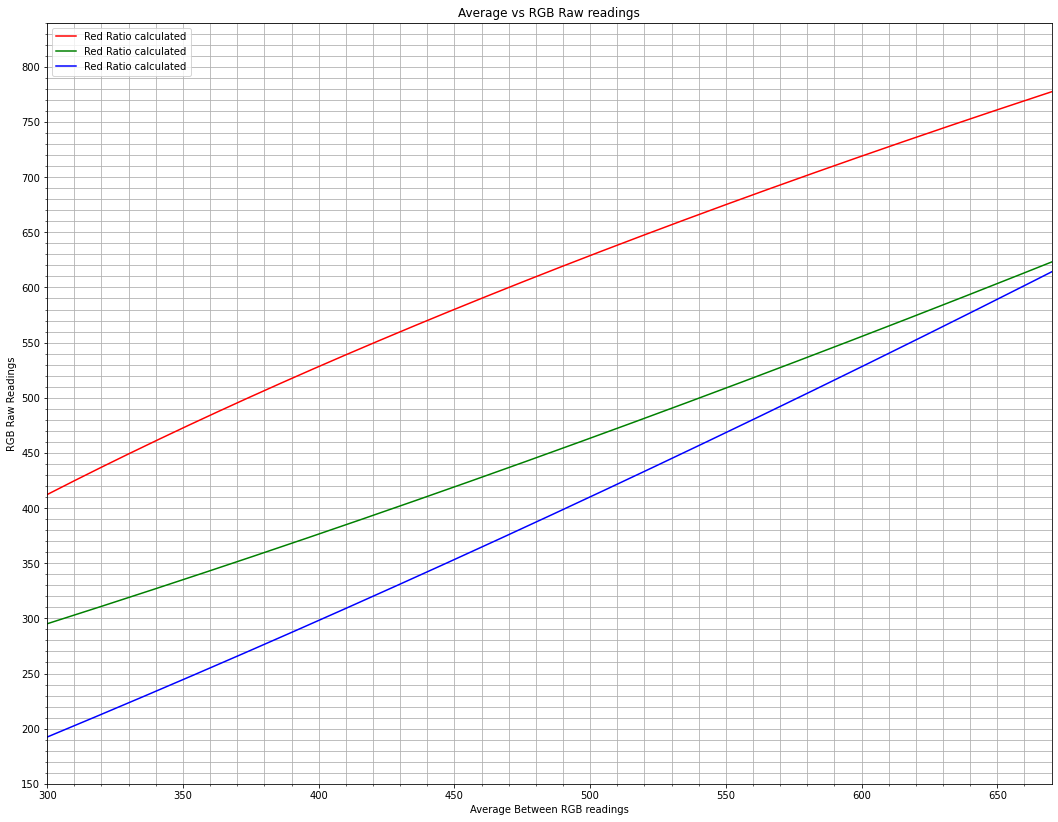

In [61]:
processRatio(average, data)

<h2> Regression Equations for R, G, B </h2>

$$R = 40.5785 \sqrt{I_{R} - 42.1185} - 239.378$$

$$G = 0.02052 (I_{G} + 347.788)^{1.5} - 43.2058$$

$$B = 0.02475 (I_{B} + 460.702)^{1.5} - 326.867$$



<h2> Inverse Equations for finding Intensity of each </h2>

$$I_{R} = (\frac{R + 239.378}{40.5785}) ^ {2} + 42.1185$$
<br>
$$I_{G} = (\frac{G + 43.2058}{0.02052}) ^ {\frac{2}{3}} - 347.788 $$
<br>
$$I_{B} = (\frac{B + 326.867}{0.02475}) ^ {\frac{2}{3}} - 460.702 $$

In [62]:
def InverteReadings(data):
    IR = np.power((data[:, 0] + 239.378) / 40.5785, 2) + 42.1185
    IG = np.power((data[:, 1] + 43.2058) / 0.02052, 2/3) - 347.788
    IB = np.power((data[:, 2] + 326.867) / 0.02475, 2/3) - 460.702

    return IR, IG, IB

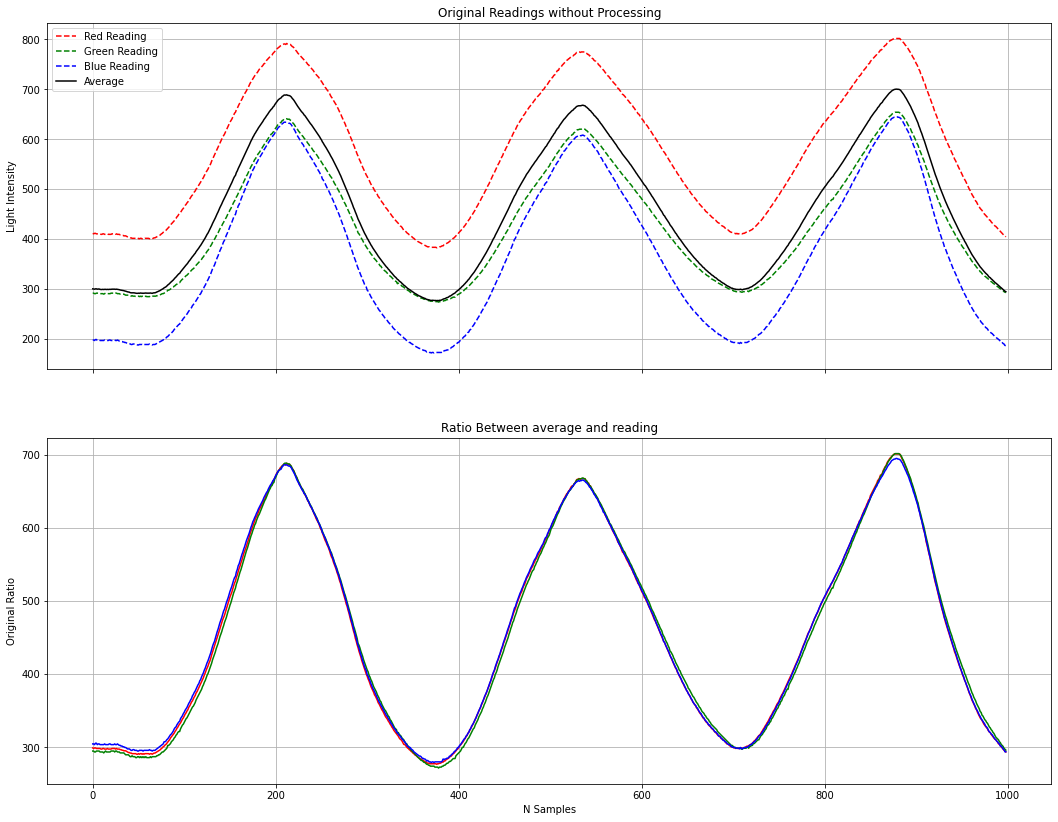

In [63]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (18, 14))

t = np.arange(0, data[:, 0].shape[0], 1)

ax[0].set_title("Original Readings without Processing")
ax[0].set_ylabel("Light Intensity")
ax[0].plot(t, data[:, 0], 'r--', label="Red Reading")
ax[0].plot(t, data[:, 1], 'g--', label="Green Reading")
ax[0].plot(t, data[:, 2], 'b--', label="Blue Reading")
ax[0].plot(t, average, 'k', label="Average")
ax[0].grid()
ax[0].legend(loc = 'upper left')

R, G, B = InverteReadings(data)

ax[1].set_xlabel("N Samples")
ax[1].set_title("Ratio Between average and reading")
ax[1].set_ylabel("Original Ratio")
ax[1].plot(t, R, 'r')
ax[1].plot(t, G, 'g')
ax[1].plot(t, B, 'b')
ax[1].grid()

plt.show()